In [329]:
import pandas as pd
from database import select_dataset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import plotly.express as px

In [330]:
# FIND WAY TO WRAP THIS CLEANLY CAUSE IT's A MESS !

aquastat = select_dataset('aquastat').dropna().drop(columns=['Area'])
aquastat = aquastat[~aquastat.ISO.isin(['USA', 'CHN', 'IND', 'RUS'])] # Not parsed !
aquastat = aquastat[~aquastat.Variable.isin(['CI', 'TC', 'ICA', 'AIR'])]
aquastat['Year'] = aquastat['Year'].astype(int)

evapotranspiration = select_dataset('evapotranspiration').dropna().drop_duplicates()
cropcalendar = select_dataset('cropcalendar')#.drop(columns=['Year'])
efficientwater = select_dataset('efficientwater')
wb_data = select_dataset('worldbank')
wb_data['Year'] = wb_data['Year'].astype(int)

crops = select_dataset('sarahcrops').replace('TC', 'CL')

crops = crops[~crops.Variable.isin(['ICA'])]
 #cropcalendar = cropcalendar[~cropcalendar.Variable.isin(['ICA'])]

MWU_df = pd.concat([aquastat, evapotranspiration, cropcalendar, efficientwater, wb_data, crops])
MWU_df = MWU_df[~MWU_df.Variable.isin(['CI'])]

In [331]:
MWU_df

,Year,Value,ISO,Variable,Description,Unit,Item
1165,1992,37.50,AFG,SW,Surface water produced internally,10^9 m3/yr,NaN
1166,1997,37.50,AFG,SW,Surface water produced internally,10^9 m3/yr,NaN
1167,2002,37.50,AFG,SW,Surface water produced internally,10^9 m3/yr,NaN
1168,2007,37.50,AFG,SW,Surface water produced internally,10^9 m3/yr,NaN
1169,2012,37.50,AFG,SW,Surface water produced internally,10^9 m3/yr,NaN
...,...,...,...,...,...,...,...
12531,2016,0.06,WLF,AIR,Agriculture area actually irrigated,1000 ha,NaN
12532,2017,0.06,WLF,AIR,Agriculture area actually irrigated,1000 ha,NaN
12533,2018,0.06,WLF,AIR,Agriculture area actually irrigated,1000 ha,NaN
12534,2010,1538.00,ZAF,AIR,Agriculture area actually irrigated,1000 ha,NaN


In [332]:
from graphmodels.graphmodel import GraphModel, concatenate_graph_specs
import numpy as np

# Conversions
height_rice = 0.2  # meter height of rice
ha_to_m2 = 1e4  # * 1e3
mm_to_m = 1  # 1e-3 TO CHECK
mmyear_to_m3year = 1  # from mm/year to m3/year as 1mm = 10m3/ha \n",

IWW_nodes = {'Kc': {'type': 'parameter', 'unit': '1', 'name': 'Crop Factor'},
             'ICA': {'type': 'input', 'unit': '1000 ha', 'name': 'Cropland area actually irrigated'},
             'CI': {'type': 'variable',
                    'unit': '1',
                    'name': 'Cropping Intensity',
                    'computation': lambda ICA, AIR, **kwargs: ICA / AIR
                    },
             'ETo': {'type': 'input', 'unit': 'mm/year', 'name': 'Evapotranspiration'},
             'ETc': {'type': 'variable',
                     'name': 'Potential Crop Evaporation Vector',
                     'unit': 'mm/year',
                     'computation': lambda Kc, CI, ETo, **kwargs: (Kc * CI * ETo).groupby(level=['ISO']).sum()
                     },
             'ETa': {'type': 'input',
                     'unit': 'mm/year',
                     'name': 'Actual Evapotranspiration'},
             'ICU': {'type': 'variable',
                     'name': 'Irrigation Consumptive Use',
                     'unit': 'mm/year',
                     'computation': lambda ETc, ETa, **kwargs: ETc - ETa  # bug to fix
                     },
             'AIR': {'type': 'parameter',
                     'unit': '1000 ha',
                     'name': 'Agriculture area actually irrigated'},
             'Arice': {'type': 'parameter',
                       'unit': '1000 ha',
                       'name': 'Area of Rice Paddy Irrigation'},
             'WRR': {'type': 'parameter', 'name': 'Water Requirement Ratio', 'unit': '1'},
             'IWR': {'type': 'variable',
                     'name': ' Irrigation Water Requirement',
                     'unit': '1e9 m3/year',
                     'computation': lambda ICU, AIR, Arice, **kwargs: 1e-9 * ha_to_m2 * mmyear_to_m3year * ((ICU * AIR) + Arice * height_rice)
                     },
             'IWW': {'type': 'variable',
                     'name': ' Irrigation Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda IWR, WRR, **kwargs: IWR / WRR * 1e2
                     },
             'AWU': {'type': 'variable', 'unit': '1e9 m3/year',
                     'name': 'Agricultural Water Withdrawal',
                     'computation': lambda IWW, **kwargs: IWW
                     },
             }


def model_MWU(GDPC, WP, Pop):
    '''Find alternative to hard coding,
    also find way to link the regression data to those coefficient to improve reproducability
    '''

    return np.exp(-0.9522 - 0.3174 * np.log(WP) + 0.5918827 * np.log(GDPC) + 0.9859812 * np.log(Pop)) * 1e-9


MWU_nodes = {'WP': {'type': 'input', 'name': 'Water Price', 'unit': '$/15m3'},
             'GDPC': {'type': 'parameter', 'name': 'GDP per capita', 'unit': '$'},
             'Pop': {'type': 'parameter', 'name': 'Population', 'unit': 'capita'},
             'MWU': {'type': 'variable',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda GDPC, WP, Pop, **kwargs: model_MWU(GDPC, WP, Pop)
                     }
             }


EW1_nodes = {'IWU': {'type': 'parameter',
                     'name': 'Industrial Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'ICA': {'type': 'input',
                     'unit': '1000 ha',
                     'name': 'Cropland area actually irrigated'},
             'MWU': {'type': 'input',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'AWU': {'type': 'input',
                     'name': 'Agricultural Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'TWW': {'type': 'variable',
                     'name': 'Total Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda AWU, IWU, MWU, **kwargs: AWU + IWU + MWU
                     },
             'AGVA': {'type': 'input',
                      'name': 'Agricultural Gross Value Added',
                      'unit': '$',
                      },

             'CL': {'type': 'parameter',
                    'unit': '1000 ha',
                    'name': 'Cropland'},
             'PAIR': {'type': 'variable',
                      'name': 'Proportion of Irrigated Cropland',
                      'unit': '1',
                      'computation': lambda ICA, CL, **kwargs: ICA.groupby(level=['ISO']).sum() / CL
                      },
             'Cr': {'type': 'variable',
                    'name': 'Corrective coefficient',
                    'unit': '1',
                    'computation': lambda PAIR, **kwargs: 1 / (1 + (PAIR / (1 - PAIR) * 0.375))
                    },

             'IGVA': {'type': 'parameter',
                      'name': 'Industrial Gross Value Added',
                      'unit': '$'},

             'SGVA': {'type': 'parameter',
                      'name': 'Service Sector Gross Value Added',
                      'unit': '$'},
             'EW1': {'type': 'output',
                     'name': 'Water Use Efficiency',
                     'unit': '$/(m3/year)',
                     'computation': lambda TWW, AGVA, IGVA, SGVA, Cr, **kwargs: (AGVA * (1 - Cr) + IGVA + SGVA) / (TWW * 1e9)
                     },
             }

In [333]:
EW1_model = GraphModel(concatenate_graph_specs([IWW_nodes, MWU_nodes, EW1_nodes]))


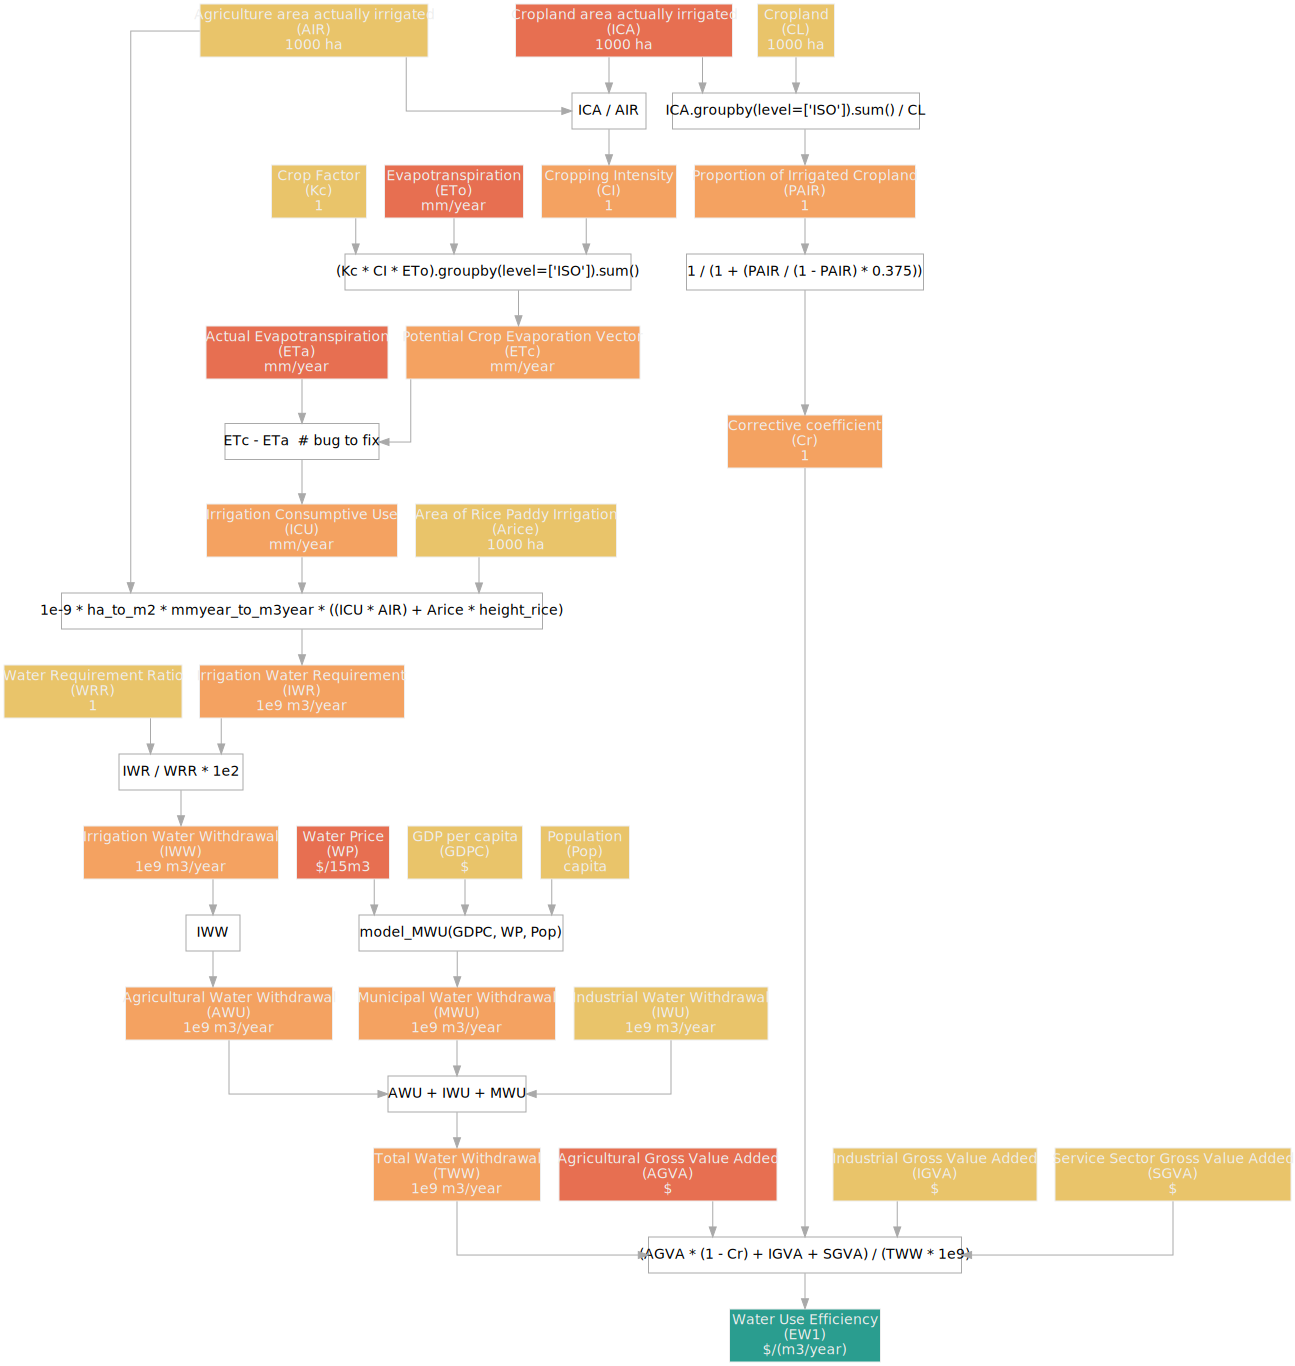

In [334]:
EW1_model.draw()

In [335]:
from graphmodels.graphmodel import GraphModel, converte_to_format, concatenate_graph_specs
import numpy as np
from graphmodels.validation import score_model, plot_diagnostic
from models.Sarah.model_EW import EW_models, MWU_model
from graphmodels.utils import get_X_y_from_data

In [336]:
def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_() + model.outputs_() if key in data_dict}
    return X, y


def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X


def fill_missing_values(df):
    return df.groupby(level='ISO').fillna(method='ffill')\
             .groupby(level='ISO').fillna(method='bfill')


def df_to_data_dict(df, itemized):
    data_dict = {}

    non_item_df = df[~df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year'], columns='Variable', values='Value')
    non_item_df = fill_missing_values(non_item_df)
    item_df = df[df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year', 'Item'], columns='Variable', values='Value')

    data_dict.update(df_to_dict(non_item_df))
    data_dict.update(df_to_dict(item_df))

    return data_dict


In [338]:
#from graphmodels.utils import df_to_data_dict

data_dict = df_to_data_dict(MWU_df, ['ICA', 'Kc'])
#data_dict['Arice'] = 0

In [339]:
X, y = get_X_y_from_data(EW1_model, data_dict)
res = EW1_model.run(X)


KeyError: 'Arice'

In [340]:
score_model(EW1_model, X, y)

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log

IWR
IWW
AWU
MWU
TWW
EW1


,r2,correlation,rmse,Variable
0,-10.445195,0.408985,1303.052510,IWR
1,-6.514330,0.239905,1170.122149,IWW
2,0.198397,0.899693,337.896362,AWU
3,0.813218,0.904427,1.011215,MWU
4,0.407340,0.888320,352.156998,TWW
5,-10.203500,0.196764,35604.867465,EW1


In [328]:
plot_diagnostic(EW1_model, X, y, 'EW1', hover_data=['ISO', 'Year'])

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



In [269]:
df = pd.concat([y['EW1'], res['EW1'], res['TWW'],], axis=1)
df.columns = ['EW1_base', 'EW1_comp', 'TWW',]

In [270]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X, y = df.dropna().drop(columns=['EW1_base']), df.dropna()['EW1_base']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [230]:
rf = Pipeline([('scaler', StandardScaler()), ('reg', LinearRegression())])
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

ValueError: Input contains infinity or a value too large for dtype('float64').

In [187]:
X.columns

Index(['EW1_comp', 'TWW'], dtype='object')

In [188]:
rf['reg'].coef_

array([16.41515804,  4.92319342])

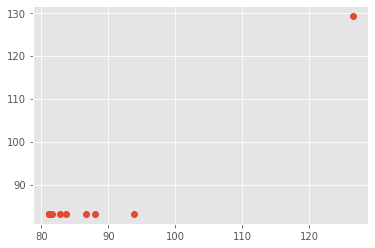

In [189]:
plt.plot(rf.predict(X_test), y_test, 'o')

# Model

In [83]:
from graphmodels.graphmodel import GraphModel, converte_to_format, concatenate_graph_specs
import numpy as np
from graphmodels.validation import score_model, plot_diagnostic
from models.Sarah.model_EW import EW_models, MWU_model
from graphmodels.utils import get_X_y_from_data

In [84]:
model = EW_models['EW1_model']

In [85]:
model.summary_df

,name,type,unit,computation
id,,,,
Kc,Crop Factor Vector,parameter,1,NaN
ICA,Irrigated crop Area,input,1000 ha,NaN
CI,Cropping Intensity,variable,1,ICA / AIR
ETo,Evapotranspiration,input,mm/year,NaN
ETc,Potential Crop Evaporation Vector,variable,mm/year,"(Kc * CI * ETo).groupby(level=['ISO', 'Year'])..."
ETa,Actual Evapotranspiration,input,mm/year,NaN
ICU,Irrigation Consumptive Use,variable,mm/year,abs(ETc - ETa) # bug to fix
AIR,Area Actually Irrigated,parameter,1000 ha,NaN
Arice,Area of Rice Paddy Irrigation,parameter,1000 ha,NaN


- TC: Should be somewhat similar to TCLD but to check

Renaming these two to avoid confusion ! 
- ICA: rename cropland area actually irrigated 
- AIR: agricultural area actually irragted

- CI to check, maybe add as an input in the back

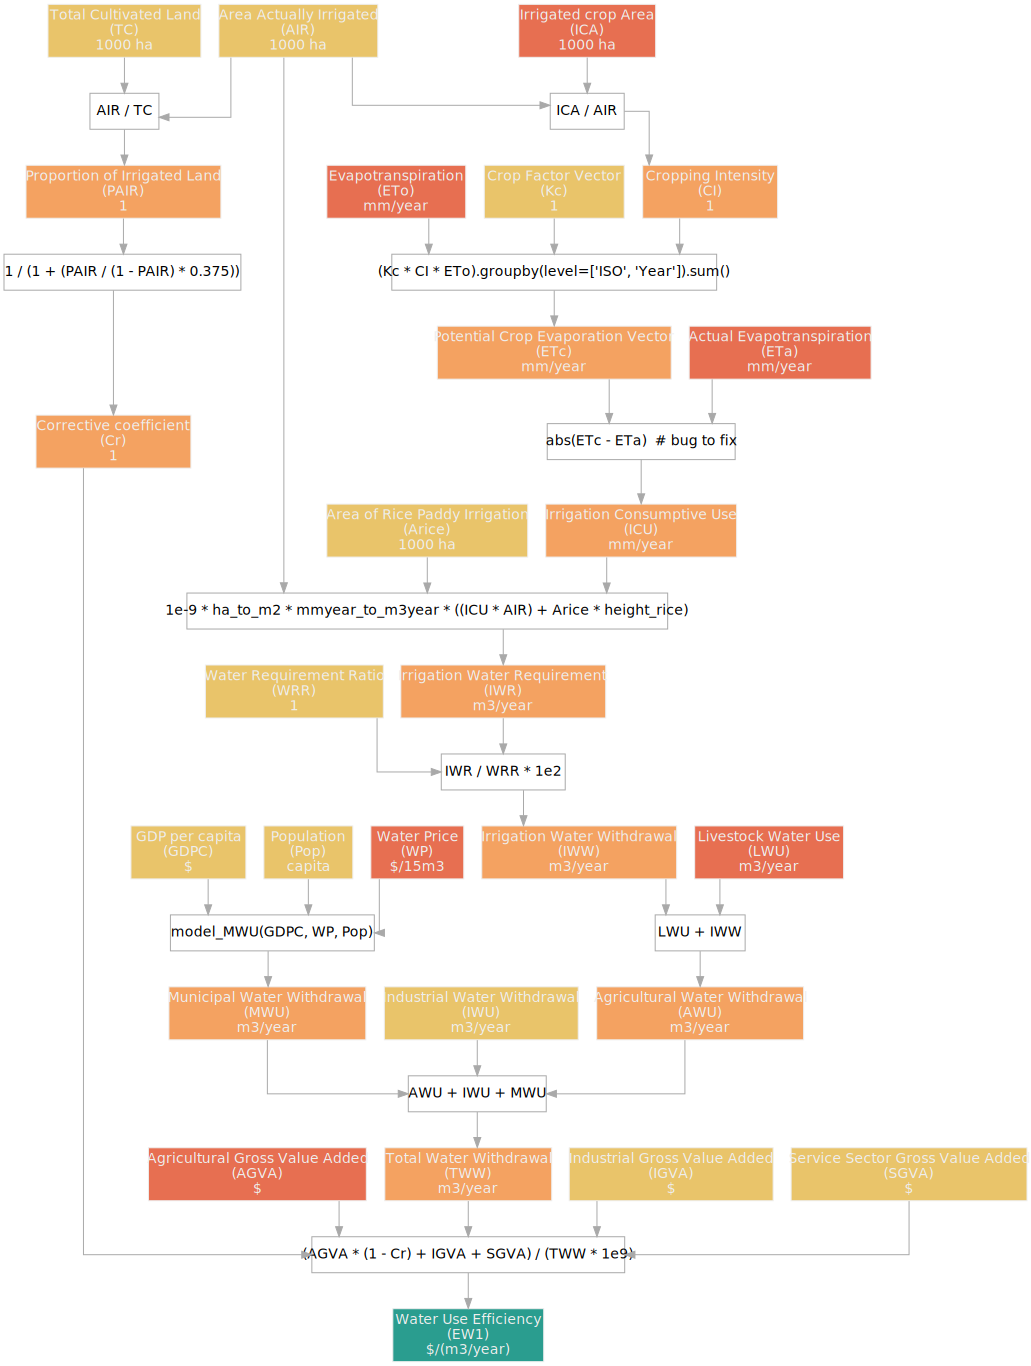

In [72]:
model.draw()

In [73]:
X, y = get_X_y_from_data(model, data_dict)
res = model.run(X)

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



In [74]:
score_model(model, X, y)

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



,r2,correlation,rmse,Variable
0,0.734552,0.859789,31.102888,IWR
1,0.036750,0.657641,285.155347,IWW
2,0.603102,0.821737,153.740444,AWU
3,0.813129,0.904383,1.014062,MWU
4,0.708943,0.862557,168.975281,TWW
5,-1.071986,0.406579,5172.641189,EW1


# Scenario Definition

First Ideas (Simon)
- Kc: Constant
- ICA: ?
- ETo: Constant for now ? 
- ETa: Same
- AIR: ? 
- Arice: ?
- WRR: Constant 
- LWU: ?
- WP: ? 
- GDPC: "Official" Projections ? 
- Pop: "Official" Projections ? 
- IWU: ? 
- AGVA: "Home made" Projections
- IGVA: "Home made" Projections
- SGVA: "Home made" Projections
- TC: ? 

Sarah Ideas: 


User set : WRR, CI

Fixed exponential growth on: TC, ICA, AIR, Arice(?) Need to be linked with Hermen's stuff to be dynamic


- Kc: Constant also maybe average out over different crops
- ICA: "Home made" projection. Use FAO (they give only one value)
- ETo: Constant !
- ETa: Constant ! 
- AIR: "Home made" projection. 
- Arice: constant for now / "home made" projection + See with Hermen's model ! 
- WRR: User set
- LWU: Zero at the moment, pop it out ! 
- WP: Annual % change over time ! 
- GDPC: "Official" Projections, not so available. Maybe "Home made" projection 
- Pop: "Official" Projections !  
- IWU: IWU should be a model on its own. No data at the moment. TO THINK ABOUT IT !
- AGVA: "Home made" Projections
- IGVA: "Home made" Projections
- SGVA: "Home made" Projections
- TC: same as other Areas



Notes:

- CI turned into an input (baseline computation in the back)

xGVA form a whole


In [101]:
model.summary_df

,name,type,unit,computation
id,,,,
Kc,Crop Factor Vector,parameter,1,NaN
ICA,Irrigated crop Area,input,1000 ha,NaN
CI,Cropping Intensity,variable,1,ICA / AIR
ETo,Evapotranspiration,input,mm/year,NaN
ETc,Potential Crop Evaporation Vector,variable,mm/year,"(Kc * CI * ETo).groupby(level=['ISO', 'Year'])..."
ETa,Actual Evapotranspiration,input,mm/year,NaN
ICU,Irrigation Consumptive Use,variable,mm/year,abs(ETc - ETa) # bug to fix
AIR,Area Actually Irrigated,parameter,1000 ha,NaN
Arice,Area of Rice Paddy Irrigation,parameter,1000 ha,NaN


In [88]:
MWU_df.query("Variable == 'IWU'")

,Year,Value,ISO,Variable,Description,Unit,Item
8052,2000.0,0.1285,AFG,IWU,Industrial water withdrawal,10^9 m3/yr,NaN
8053,2005.0,0.1695,AFG,IWU,Industrial water withdrawal,10^9 m3/yr,NaN
8054,1990.0,0.1000,ALB,IWU,Industrial water withdrawal,10^9 m3/yr,NaN
8055,2000.0,0.2274,ALB,IWU,Industrial water withdrawal,10^9 m3/yr,NaN
8056,2005.0,0.2318,ALB,IWU,Industrial water withdrawal,10^9 m3/yr,NaN
...,...,...,...,...,...,...,...
8601,1994.0,0.1180,ZMB,IWU,Industrial water withdrawal,10^9 m3/yr,NaN
8602,2000.0,0.1300,ZMB,IWU,Industrial water withdrawal,10^9 m3/yr,NaN
8603,2002.0,0.2980,ZWE,IWU,Industrial water withdrawal,10^9 m3/yr,NaN
8604,2007.0,0.2150,ZWE,IWU,Industrial water withdrawal,10^9 m3/yr,NaN


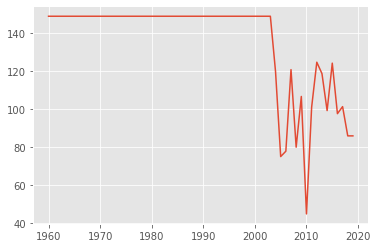

In [352]:
plt.plot(data_dict['AIR'].loc['HUN'])

<AxesSubplot:xlabel='Year', ylabel='Value'>

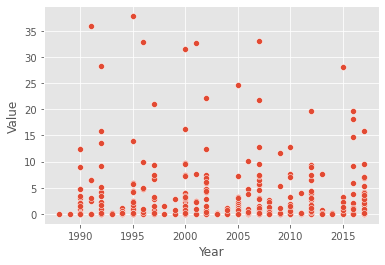

In [89]:
sns.scatterplot(data=MWU_df.query("Variable == 'IWU'"), x='Year', y='Value')

In [77]:
model.summary_df.query("type in ['parameter', 'input']")

,name,type,unit,computation
id,,,,
Kc,Crop Factor Vector,parameter,1,NaN
ICA,Irrigated crop Area,input,1000 ha,NaN
ETo,Evapotranspiration,input,mm/year,NaN
ETa,Actual Evapotranspiration,input,mm/year,NaN
AIR,Area Actually Irrigated,parameter,1000 ha,NaN
Arice,Area of Rice Paddy Irrigation,parameter,1000 ha,NaN
WRR,Water Requirement Ratio,parameter,1,NaN
LWU,Livestock Water Use,input,m3/year,NaN
WP,Water Price,input,$/15m3,NaN


In [83]:
MWU_df.query("Variable == 'C'")

,Year,Value,ISO,Variable,Description,Unit,Item


<AxesSubplot:xlabel='Year', ylabel='Value'>

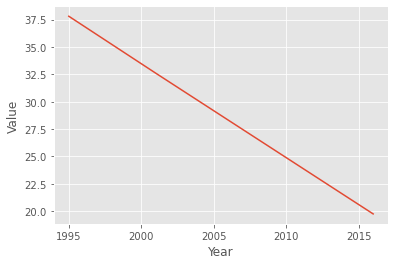

In [95]:
sns.lineplot(data=MWU_df.query("Variable == 'IWU' and ISO == 'DEU'"), x='Year', y='Value')

In [70]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


<AxesSubplot:xlabel='Year', ylabel='Value'>

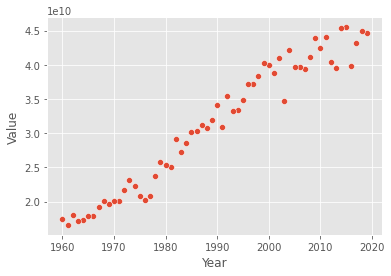

In [62]:
sns.scatterplot(data=MWU_df.query("Variable == 'AGVA' and ISO == 'FRA'"), x='Year', y='Value')

<AxesSubplot:xlabel='Year', ylabel='Value'>

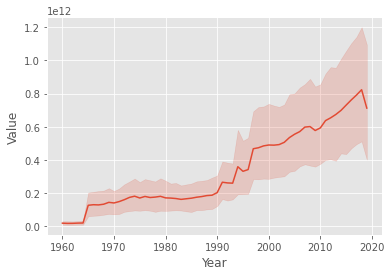

In [96]:
sns.lineplot(data=MWU_df.query("Variable == 'IGVA'"), x='Year', y='Value')

# EW2 every constant except TWW which comes from the previous model ! 

Change Natural EW2 to something less confusing with EW2 

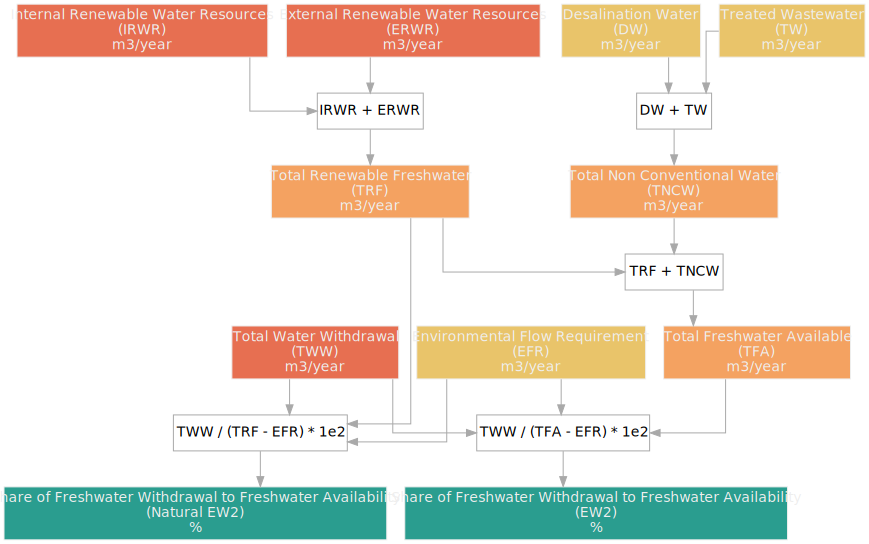

In [103]:
EW_models['EW2_partial_model'].draw()

Display of results:

- EW1, EW2, Natural EW2: Lineplots + To try: Confidence Interval on full distribution of countries)
- Context: GDP, Pop



To try pick countries with different climates 